In [313]:
# import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None) #setting max colwidth to view the entire dataset when using the print() command
import matplotlib.pyplot as plt
import numpy as np

In [314]:
# import the files
data = open("./dataset/breast-cancer.data")
feat = open("./dataset/breast-cancer.names")

data = data.read()
feat = feat.read()

In [315]:
# preview the first two rows of the dataset
print(data.split('\n',1)[0])
print(data.split('\n',2)[1])

no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no


In [316]:
# view information about the dataset
print(feat)

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [317]:
# replace missing dataset attributes to NAN
data = data.replace('?','')

In [318]:
from io import StringIO

In [319]:
# convert data from str to dataframe
data = StringIO(data)
data = pd.read_csv(data, sep=",")
print(type(data)) #check the data variable is a pandas.core.frame.DataFrame

<class 'pandas.core.frame.DataFrame'>


In [320]:
data.columns = ['class', 'age', 'menopause', 'tumour_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irrad']
data.columns

Index(['class', 'age', 'menopause', 'tumour_size', 'inv_nodes', 'node_caps',
       'deg_malig', 'breast', 'breast_quad', 'irrad'],
      dtype='object')

In [321]:
data['class'] = data['class'].replace(['no-recurrence-events','recurrence-events'], [0,1])
data['age'] = data['age'].replace(['20-29', '30-39','40-49','50-59','60-69','70-79'],[0,1,2,3,4,5])
data['menopause'] = data['menopause'].replace(['premeno','ge40','lt40'],[0,1,2])
data['tumour_size'] = data['tumour_size'].replace(['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54'],[0,1,2,3,4,5,6,7,8,9,10])
data['inv_nodes'] = data['inv_nodes'].replace(['0-2','3-5','6-8','9-11','12-14','15-17','24-26'],[0,1,2,3,4,5,6])
data['node_caps'] = data['node_caps'].replace(['no','yes'],[0,1])
data['breast'] = data['breast'].replace(['left','right'],[0,1])
data['breast_quad'] = data['breast_quad'].replace(['left_low','left_up','right_up','right_low','central'],[0,1,2,3,4])
data['irrad'] = data['irrad'].replace(['no','yes'],[0,1])

In [322]:
# replace missing data 
data['node_caps'] = data['node_caps'].fillna(5)
data['breast_quad'] = data['breast_quad'].fillna(8)

In [323]:
X = data.drop(['class'], axis = 1)
y = data['class']

In [324]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [325]:
X_train.shape

(228, 9)

In [326]:
y_train.shape

(228,)

In [327]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 214 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          228 non-null    int64  
 1   menopause    228 non-null    int64  
 2   tumour_size  228 non-null    int64  
 3   inv_nodes    228 non-null    int64  
 4   node_caps    228 non-null    float64
 5   deg_malig    228 non-null    int64  
 6   breast       228 non-null    int64  
 7   breast_quad  228 non-null    float64
 8   irrad        228 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 17.8 KB


In [328]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 228 entries, 214 to 250
Series name: class
Non-Null Count  Dtype
--------------  -----
228 non-null    int64
dtypes: int64(1)
memory usage: 3.6 KB


<AxesSubplot: >

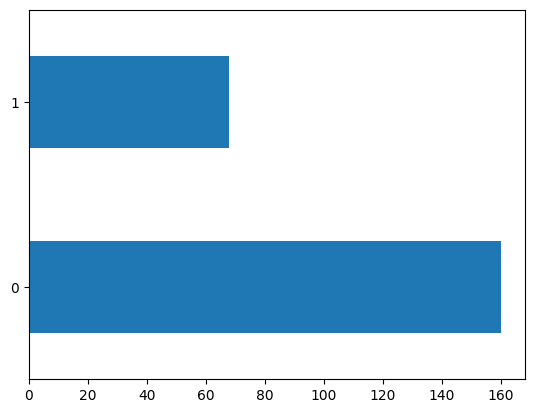

In [329]:
class_ = y_train.value_counts()
class_.plot.barh()

#### Model

- target class is unbalanced
- in general, 10.4% is the rate of breast cancer recurrence after 5 years from the initial cancer. Unbalanced may be representative of real-world situation
- type of errors in real-world deployment of the model:
  - false negatives: failing to detect likely recurrence *"patient won't experience recurrence but likely will"*
  - false positives: marking recurrence when patient likely won't *"patient will experience recurrence, but likely won't"*
  - damaging: false negatives > false positives
- cost-sensitive model that is designed to prioritize recall over precision may be more appropriate
  - *cost-sensitive model: "takes into account consequences of different types of errors when making predictions"*
  - *recall: "ability to detect all instances of the disease"*
  - *precision: "correctly identify positive instances"*
  - *F1-score: "a mix of precision and recall. Good when the target class is unbalanced"*
  <br>
  <br>
- several options:
  - try to evaluate the model using appropriate evaluation metrics
    - F1-score, ROC-AUC
  - model a cost-sensitive model that prioritizes recall over precision and test the model again
  - balance the target class using sampling methods
  - setting a minimum threshold for prediction

In [330]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score

from imblearn.over_sampling import RandomOverSampler

from IPython.display import display

def normal_pred(model, X_train, y_train, X_test, y_test):
    #normal model
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    n_acc = model.score(X_train, y_train)
    n_f1 = f1_score(y_test, y_pred, average='binary')
    y_score = model.predict_proba(X_test)[:, 1]
    n_roc_auc = roc_auc_score(y_test, y_score)
    n_rec = recall_score(y_test, y_pred)
    n_pre = precision_score(y_test, y_pred)
    return n_acc, n_f1, n_roc_auc, n_rec, n_pre



def cost_sensitive(model, X_train, y_train, X_test, y_test):
    if model == 'RandomForestClassifier()':
        model = RandomForestClassifier(class_weight={0: 1, 1: 2})
    if model == 'LogisticRegression()':
        model = LogisticRegression(class_weight={0: 1, 1: 2})
    if model == 'DecisionTreeClassifier()':
        model = DecisionTreeClassifier(class_weight={0: 1, 1: 2})
    if model == 'KNeighborsClassifier(n_neighbors=5)':
        model = KnNeighborsClassifier(n_neighbors=5,class_weight={0: 1, 1: 2})
    # cost-sensitive prioritizing recall model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    c_acc = model.score(X_train, y_train)
    c_f1 = f1_score(y_test, y_pred, average='binary')
    c_roc_auc = 0
    c_rec = recall_score(y_test, y_pred)
    c_pre = precision_score(y_test, y_pred)
    return c_acc, c_f1, c_roc_auc, c_rec, c_pre


def resampling(model, X_train, y_train, X_test, y_test):
    # resampling to make target class balanced
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    r_acc = model.score(X_train, y_train)
    r_f1 = f1_score(y_test, y_pred, average='binary')
    y_score = model.predict_proba(X_test)[:, 1]
    r_roc_auc = roc_auc_score(y_test, y_score)
    r_rec = recall_score(y_test, y_pred)
    r_pre = precision_score(y_test, y_pred)
    return r_acc, r_f1, r_roc_auc, r_rec, r_pre


def threshold(model, X_train, y_train, X_test, y_test):
    model = model
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    threshold = 0.35
    y_pred = (y_score >= threshold).astype(int)
    t_acc = 0
    t_f1 = f1_score(y_test, y_pred, average='binary')
    t_roc_auc = roc_auc_score(y_test, y_pred)
    t_rec = recall_score(y_test, y_pred)
    t_pre = precision_score(y_test, y_pred)
    return t_acc, t_f1, t_roc_auc, t_rec, t_pre


def cross_val(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    return mean_score, std_score


def metrics_table(a,b,c,d,e,f,g,h,i,l,m,n,o,p,q,r,s,t,u,v,mean,std,model):
    data = [[a,b,c,d,e],[f,g,h,i,l],[m,n,o,p,q],[r,s,t,u,v]]
    index = ['Normal', 'Cost-sensitive Resampling', 'Sampling to Balanced', 'Minimum Threshold']
    table = pd.DataFrame(data, columns=['Accuracy', 'F1-score', 'ROC-AUC', 'Recall', 'Precision'], index=index)
    table = table.style.highlight_between(left=0.68, right=0.99, color="#276221")
    print(model, 'Cross-Validation Mean:', mean, 'Standard-dev:', std)
    print(display(table))
    print('\n')


def mod_eval(model, X_train, y_train, X_test, y_test):
    n_acc, n_f1, n_roc_auc, n_rec, n_pre = normal_pred(model, X_train, y_train, X_test, y_test)
    c_acc, c_f1, c_roc_auc, c_rec, c_pre = cost_sensitive(model, X_train, y_train, X_test, y_test)
    r_acc, r_f1, r_roc_auc, r_rec, r_pre = resampling(model, X_train, y_train, X_test, y_test)
    t_acc, t_f1, t_roc_auc, t_rec, t_pre = threshold(model, X_train, y_train, X_test, y_test)
    mean_score, std_score = cross_val(model, X_train, y_train)
    metrics_table(n_acc,n_f1,n_roc_auc,n_rec,n_pre,c_acc,c_f1,c_roc_auc,c_rec,c_pre,r_acc,r_f1,r_roc_auc,r_rec,r_pre,t_acc,t_f1,t_roc_auc,t_rec,t_pre,mean_score,std_score,model)

In [331]:
models = [RandomForestClassifier(),LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), SVC(kernel='linear', probability=True)]

for model in models:
    mod_eval(model, X_train, y_train, X_test, y_test)

RandomForestClassifier() Cross-Validation Mean: 0.7190338164251209 Standard-dev: 0.02819303142505215


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.986842,0.466667,0.569853,0.411765,0.538462
Cost-sensitive Resampling,0.986842,0.400000,0.000000,0.352941,0.461538
Sampling to Balanced,0.986842,0.424242,0.595588,0.411765,0.437500
Minimum Threshold,0.000000,0.350000,0.505882,0.411765,0.304348


None


LogisticRegression() Cross-Validation Mean: 0.7371980676328502 Standard-dev: 0.055925255927063905


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.741228,0.516129,0.660294,0.470588,0.571429
Cost-sensitive Resampling,0.741228,0.516129,0.000000,0.470588,0.571429
Sampling to Balanced,0.706140,0.500000,0.635294,0.588235,0.434783
Minimum Threshold,0.000000,0.487805,0.619118,0.588235,0.416667


None


DecisionTreeClassifier() Cross-Validation Mean: 0.6403864734299517 Standard-dev: 0.08850399762313808


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.986842,0.368421,0.530882,0.411765,0.333333
Cost-sensitive Resampling,0.986842,0.368421,0.000000,0.411765,0.333333
Sampling to Balanced,0.986842,0.363636,0.551471,0.352941,0.375000
Minimum Threshold,0.000000,0.324324,0.501471,0.352941,0.300000


None


KNeighborsClassifier() Cross-Validation Mean: 0.697487922705314 Standard-dev: 0.03646162268495201


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.780702,0.320000,0.495588,0.235294,0.500000
Cost-sensitive Resampling,0.780702,0.320000,0.000000,0.235294,0.500000
Sampling to Balanced,0.754386,0.333333,0.573529,0.294118,0.384615
Minimum Threshold,0.000000,0.243902,0.409559,0.294118,0.208333


None


SVC(kernel='linear', probability=True) Cross-Validation Mean: 0.7108212560386473 Standard-dev: 0.03551247127090702


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.750000,0.320000,0.633824,0.235294,0.500000
Cost-sensitive Resampling,0.750000,0.320000,0.000000,0.235294,0.500000
Sampling to Balanced,0.710526,0.512821,0.630882,0.588235,0.454545
Minimum Threshold,0.000000,0.384615,0.597059,0.294118,0.555556


None




#### Feature Engineering

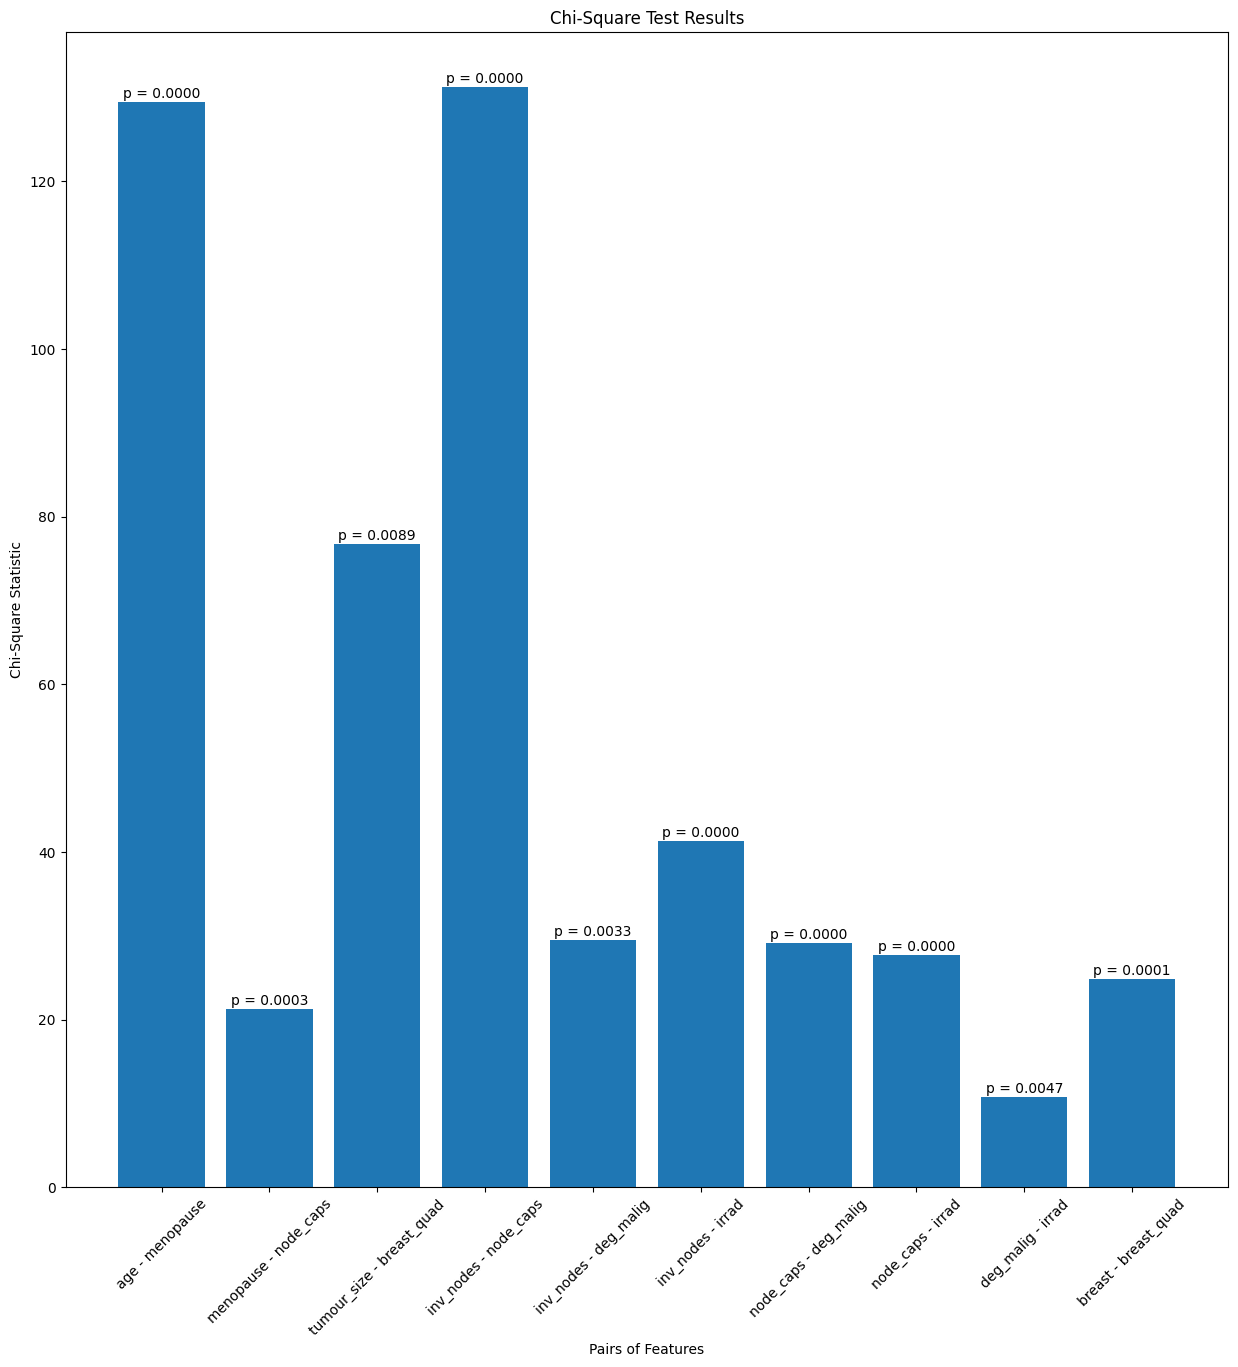

In [332]:
# perform correlation between attributes with non-continuous data
from scipy.stats import chi2_contingency

columns = X_train.columns
results = []
for i, column1 in enumerate(columns):
    for column2 in columns[i + 1:]:
        table = pd.crosstab(X_train[column1], X_train[column2])
        chi2, p, dof, expected = chi2_contingency(table)
        if p <= 0.05:
            results.append([column1, column2, chi2, p])

# plot the results
x = [f"{result[0]} - {result[1]}" for result in results]
y = [result[2] for result in results]
p = [result[3] for result in results]

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.bar(x, y)

for i, v in enumerate(y):
    ax.text(i, v + 0.5, f"p = {p[i]:.4f}", ha='center')

plt.title("Chi-Square Test Results")
plt.xlabel("Pairs of Features")
plt.ylabel("Chi-Square Statistic")
plt.xticks(rotation=45)
plt.show()

In [333]:
X_train['size_agg'] = X_train['tumour_size'] + X_train['deg_malig']
X_test['size_agg'] = X_test['tumour_size'] + X_test['deg_malig']

#### Feature Importance & Selection

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'age'),
  Text(1, 0, 'menopause'),
  Text(2, 0, 'tumour_size'),
  Text(3, 0, 'inv_nodes'),
  Text(4, 0, 'node_caps'),
  Text(5, 0, 'deg_malig'),
  Text(6, 0, 'breast'),
  Text(7, 0, 'breast_quad'),
  Text(8, 0, 'irrad'),
  Text(9, 0, 'size_agg')])

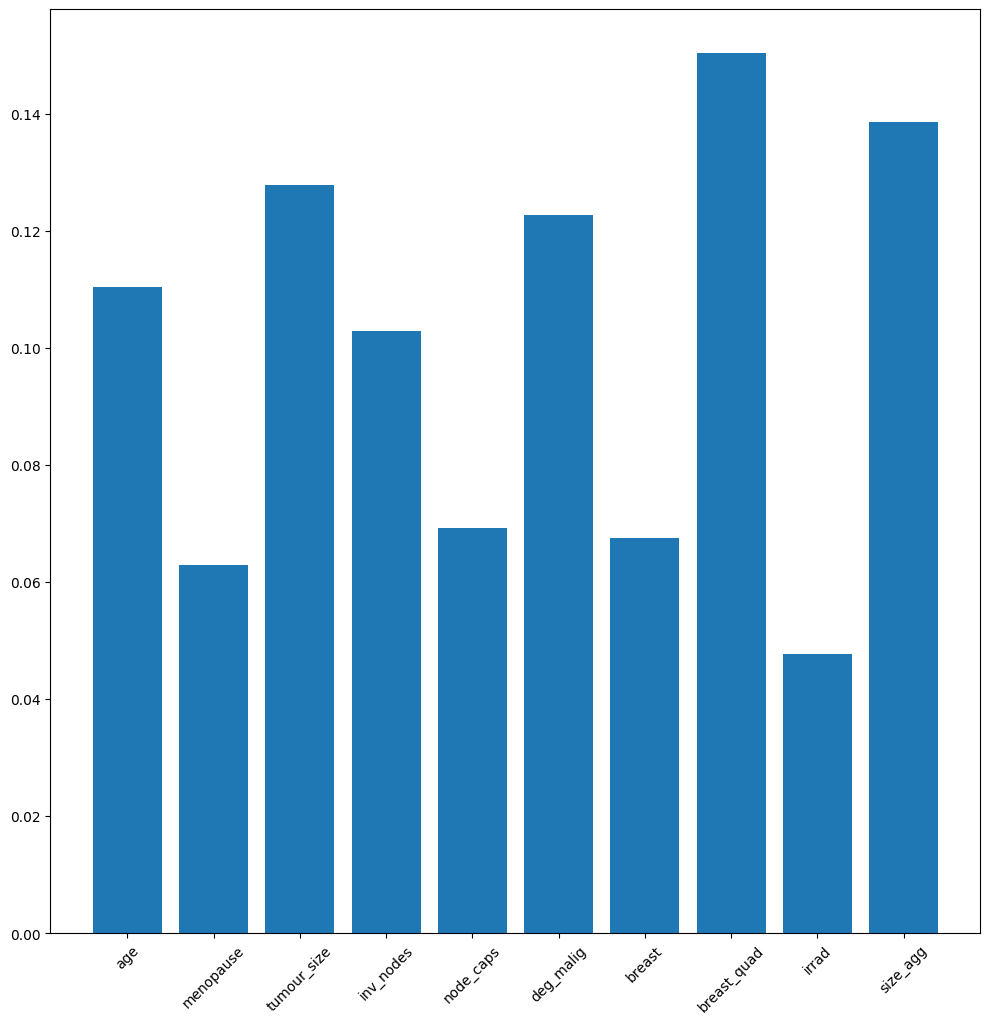

In [334]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

plt.figure(figsize=(12,12))
plt.bar(X_train.columns, clf.feature_importances_)
plt.xticks(rotation=45)

In [335]:
important_features = ['tumour_size', 'breast_quad', 'size_agg']
X_train = X_train[important_features]
X_test = X_test[important_features]

In [336]:
for model in models:
    mod_eval(model, X_train, y_train, X_test, y_test)

RandomForestClassifier() Cross-Validation Mean: 0.6976811594202899 Standard-dev: 0.048663819056024606


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.837719,0.428571,0.718382,0.352941,0.545455
Cost-sensitive Resampling,0.837719,0.444444,0.000000,0.352941,0.600000
Sampling to Balanced,0.798246,0.666667,0.738235,0.764706,0.590909
Minimum Threshold,0.000000,0.578947,0.698529,0.647059,0.523810


None


LogisticRegression() Cross-Validation Mean: 0.6884057971014493 Standard-dev: 0.05033807152717079


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.728070,0.516129,0.669118,0.470588,0.571429
Cost-sensitive Resampling,0.728070,0.516129,0.000000,0.470588,0.571429
Sampling to Balanced,0.679825,0.476190,0.667647,0.588235,0.400000
Minimum Threshold,0.000000,0.487805,0.619118,0.588235,0.416667


None


DecisionTreeClassifier() Cross-Validation Mean: 0.7194202898550726 Standard-dev: 0.03079292384282744


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.837719,0.240000,0.690441,0.176471,0.375000
Cost-sensitive Resampling,0.837719,0.240000,0.000000,0.176471,0.375000
Sampling to Balanced,0.802632,0.684211,0.763235,0.764706,0.619048
Minimum Threshold,0.000000,0.540541,0.669118,0.588235,0.500000


None


KNeighborsClassifier() Cross-Validation Mean: 0.6714009661835749 Standard-dev: 0.11494596290924677


,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.802632,0.500000,0.668382,0.411765,0.636364
Cost-sensitive Resampling,0.802632,0.500000,0.000000,0.411765,0.636364
Sampling to Balanced,0.785088,0.500000,0.680882,0.529412,0.473684
Minimum Threshold,0.000000,0.478261,0.598529,0.647059,0.379310


None


SVC(kernel='linear', probability=True) Cross-Validation Mean: 0.6840579710144927 Standard-dev: 0.03149224933327669


C:\Users\Premiere2022-PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Premiere2022-PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Premiere2022-PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: Undefin

,Accuracy,F1-score,ROC-AUC,Recall,Precision
Normal,0.701754,0.000000,0.600735,0.000000,0.000000
Cost-sensitive Resampling,0.701754,0.000000,0.000000,0.000000,0.000000
Sampling to Balanced,0.570175,0.490566,0.651471,0.764706,0.361111
Minimum Threshold,0.000000,0.000000,0.500000,0.000000,0.000000


None


